<a href="https://colab.research.google.com/github/abhayhck/cancer/blob/main/Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0


--2023-07-14 06:27:20--  https://www.dropbox.com/s/dtw18saps0231yn/BrainTumorData.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/dtw18saps0231yn/BrainTumorData.zip [following]
--2023-07-14 06:27:20--  https://www.dropbox.com/s/raw/dtw18saps0231yn/BrainTumorData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 404 Not Found
2023-07-14 06:27:20 ERROR 404: Not Found.



In [ ]:
#!unzip /content/BrainTumorData.zip?dl=0

In [ ]:

#!mv /BrainTumorData /content
#"/content/BrainTumorData/Brain Tumor Data Set"

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import shutil
import glob
import math
import numpy as np


In [ ]:
root_dir="/BrainTumorData/Brain Tumor Data Set"
no_of_img={}   #making a dictionary
for dir in os.listdir(root_dir):
    if dir=='.ipynb_checkpoints':
      continue
    no_of_img[dir]=len(os.listdir(os.path.join(root_dir,dir)))
print(no_of_img)

{'Brain Tumor': 2513, 'Healthey': 2087}


In [ ]:
def datafolder(p,split):
    if not os.path.exists("/content/BrainTumorData/"+p):
        os.mkdir("/content/BrainTumorData/"+p)
        for dir in os.listdir(root_dir):
            if dir=='.ipynb_checkpoints':
              continue
            os.makedirs("/content/BrainTumorData/"+p+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)),
                                    size=(math.floor(split*no_of_img[dir]-5))):
                o=os.path.join(root_dir,dir,img)
                d=os.path.join("/content/BrainTumorData/"+p,dir)
                shutil.copy(o,d)
                #os.remove(o)
    else:
        print(f"{p}folder exists")


In [ ]:
#shutil.rmtree('/content/BrainTumorData')

In [ ]:
datafolder("train",0.7)

In [ ]:
datafolder("val", 0.15)

In [ ]:
datafolder("test", 0.15)

In [ ]:
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, MaxPool2D, BatchNormalization, GlobalAvgPool2D


from keras.preprocessing.image import ImageDataGenerator
import keras


In [ ]:
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))

model.add(Conv2D(filters=36, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 36)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=['accuracy'])


**Using Image data generator to use our data**

In [ ]:
def prepro_img1(path):
  '''
  input will be a path
  output will be a pre processed image
  '''
  image_data=ImageDataGenerator(zoom_range=0.2, shear_range=0.2, rescale=1/255, horizontal_flip=True)
  image=image_data.flow_from_directory(directory=path, target_size=(224,224),batch_size=32, class_mode='binary')
  return image

In [ ]:
path="/content/BrainTumorData/train"
train_data = prepro_img1(path)

Found 2276 images belonging to 2 classes.


In [ ]:
def prepro_img2(path):
  '''
  input will be a path
  output will be a pre processed image
  '''
  image_data=ImageDataGenerator( rescale=1/255)
  image=image_data.flow_from_directory(directory=path, target_size=(224,224),batch_size=32, class_mode='binary')
  return image

In [ ]:
path="/content/BrainTumorData/test"
test_data = prepro_img2(path)

Found 633 images belonging to 2 classes.


In [ ]:
path="/content/BrainTumorData/val"
val_data = prepro_img2(path)

Found 630 images belonging to 2 classes.


In [ ]:
# Early stopping and model check point

from keras.callbacks import ModelCheckpoint, EarlyStopping

#early stopping
es=EarlyStopping(monitor="val_accuracy", min_delta=0.01, patience=5, verbose=1, mode='auto')
#model checkpoint
mc=ModelCheckpoint(monitor="val_accuracy", filepath="/content/bestmodel.h5", verbose=1, save_best_only=True, mode='auto')
cd=[es, mc]

**Model Training**

In [ ]:
hs=model.fit_generator(generator=train_data,
                       steps_per_epoch=8,
                       epochs=30,
                       verbose=1,
                       validation_data=val_data,
                       validation_steps=16,
                       callbacks=cd)

Epoch 1/30
8/8 [==============================] - ETA: 0s - loss: 0.9072 - accuracy: 0.5742
Epoch 00001: val_accuracy improved from -inf to 0.54102, saving model to /content/bestmodel.h5
8/8 [==============================] - 18s 881ms/step - loss: 0.9072 - accuracy: 0.5742 - val_loss: 0.6735 - val_accuracy: 0.5410
Epoch 2/30
8/8 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.5703
Epoch 00002: val_accuracy improved from 0.54102 to 0.55664, saving model to /content/bestmodel.h5
8/8 [==============================] - 7s 880ms/step - loss: 0.6682 - accuracy: 0.5703 - val_loss: 0.7056 - val_accuracy: 0.5566
Epoch 3/30
8/8 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.5469
Epoch 00003: val_accuracy improved from 0.55664 to 0.60156, saving model to /content/bestmodel.h5
8/8 [==============================] - 7s 885ms/step - loss: 0.6965 - accuracy: 0.5469 - val_loss: 0.6407 - val_accuracy: 0.6016
Epoch 4/30
8/8 [=============================

In [ ]:
import matplotlib.pyplot as plt
h=hs.history
print(h.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


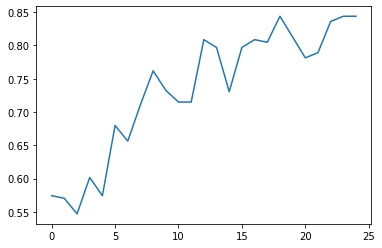

In [ ]:
plt.plot(h['accuracy'])

**Accuracy---**

In [ ]:
from keras.models import load_model
model=load_model("/content/bestmodel.h5")


In [ ]:
acc=model.evaluate_generator(test_data)[1]
print(f"The accuracy of our Model is {acc*100}%")

The accuracy of our Model is 83.41231942176819%


In [ ]:

from keras.preprocessing.image import load_img, img_to_array

In [ ]:
train_data.class_indices

{'Brain Tumor': 0, 'Healthey': 1}

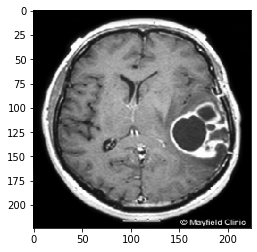

MRI is having a tumor


In [ ]:
path="/content/BrainTumorData/Brain Tumor Data Set/Brain Tumor/Cancer (1000).jpg"
img=load_img (path,target_size=(224,224))
input_arr=img_to_array(img)/255
plt.imshow(input_arr)
plt.show()
input_arr.shape
input_arr=np.expand_dims(input_arr, axis=0)
pred=(model.predict(input_arr) > 0.5).astype("int32")
if pred[0][0]==0:
  print("MRI is having a tumor")
else:
  print("MRI is not having a tumor")